# Investigation into the effect of Viscosity on gravity driven fluid oscillation in a straw

In [2]:
#importing all using libraries
import numpy as np
import scipy as sp
import math as math
from ipywidgets import interact
from scipy.integrate import odeint
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib widget
%matplotlib inline


By exporting all of the tracker data into a format of .dat, we are able to utilize and directly import the data into jupyter notebook.

In [12]:
#importing data
file_dir = './data/'
filename= '400mLblaackballTrial2.dat'

data = np.genfromtxt(file_dir+filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,2]

timeshift= 0.267 # the time shifting varaible, shifted so that t = 0, is when the stopper is removed.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean = z_data[np.isfinite(z_data)]

By plotting the data now, we are able to adjust the timeshift variable, while also providing a small window into how the data looks like.

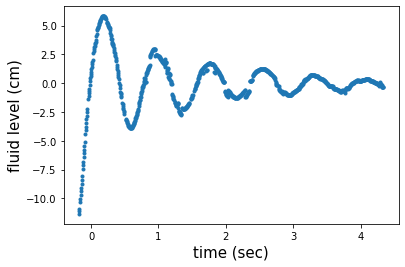

In [4]:
# plotting the raw data
plt.plot(time_data_clean[8:],z_data_clean[8:],'.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.show()

Now we would need to fill in some constants in each trial to calculate the initial condition of the fluid in the straw.

In [5]:
# calculate the initial starting level of the fluid in the submersed straw:
density = 1068.0 # g/cm^3
atmPressure = 1000 # g/cm^2
h = 8 # length submerged
H = 30  # length of straw, cm
d = (1 - atmPressure/(density*h + atmPressure))*H
print('fluid level will be %2.2f cm above the bottom of the straw'%(d))

fluid level will be 26.86 cm above the bottom of the straw


**Viscosity would have an impact on the pressure force through the Poiseuille equation**

$$
\begin{aligned}
\Delta P = \frac{\mu LQ}{\pi R^4}
\end{aligned}
$$

Where $\Delta$P could be defined as $P_{bottom}$ - $P_{atm}$, where $P_{bottom}$ is the pressure at the bottom of the straw

therefore, the pressure force at the bottom of the straw could be defined as

$$
\begin{aligned}
P_{bottom} = \frac{\pi R^4 P_{atm}-8 \mu LA Z^{\prime}}{\pi R^4}
\end{aligned}
$$

**Solving the second order ordinary differencial equation**

$$
\begin{aligned}
\frac{dp}{dt} = -mg + \frac{\pi R^4 P_{atm}-8 \mu LA Z^{\prime}}{\pi R^4} - \frac{bZ^{\prime}}{Z}- \frac{(Z^{\prime})^2}{Z}
\end{aligned}
$$

Now solving for $Z^{\prime\prime}$

$$
\begin{aligned}
Z^{\prime\prime}= -\frac{1}{Z}(\frac{P_{atm}-\frac{8\mu LA Z^{\prime}}{\pi R^4}}{\rho Z}-bZ^{\prime}-(Z^{\prime})^2)-g
\end{aligned}
$$


In [22]:
# Solving the Newton's law model and also equations 17a and 17b from Lorenceau paper:
#Where Z[0] = y axis displacement with adjusted height through H
#Where Z[1] is the first derivative of Z?

# Newton's law model
def DZ_dt_Newton(Z, t,args):
    h = args[0]
    g = args[1]
    b = args[2]
    
    #constants
    rho = 1068.0 #kg/m^3
    A = 0.075438 #cross sectional area. PiR^2
    L = 0.2 #length of tube(m)
    mu = 0.024225 #dynamic viscosity (poise)
    R = 0.0155 #radius (m)
    pATM = 101325 #atm pa
    
    #k = ((math.pi*(R**4)*pATM)+(8*math.pi*mu*L*A*Z[1]))/(math.pi*R**4*rho*Z[0]) #Pressure Force
    #k = ((math.pi*(R**4)*pATM)+(8*math.pi*mu*L*A*Z[1]))/(math.pi*R**4*rho*Z[0])* #Pressure Force
    k = (pATM-((8*mu*L*A*Z[1])/math.pi*R**4))/(rho*Z[0]) #pressure force
    #print(k)
    
    by = (-1*b*Z[1])/Z[0]
    
    y2 = (-1*Z[1]**2/Z[0])
    
    inside = k-by-y2
    
    #print(outside)
    
    final = inside-g #final return
    
    '''print("my model :")
    print(final)
    
    print("Working Model :")
    print((-Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]))'''
    
    print("Pressure force w/out viscosity:")
    print(g*h/Z[0])
    print("Pressure force with viscosity:")
    print(k)
    
    try:
        #print(f)
        #return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]] #newtonian model without viscosity
        #return [Z[1], ((k+b)*Z[1]-Z[1]**2/Z[0])-g]
        return [Z[1], final] #newest test model
    except:
        print("something wrong")
    
    #energy lost due to friction to the walls
    #hL = f*(L/D)*(v^2/2g), where f for laminar flow = 64/(v*D*rho/dynamic viscosity)
    #therefore, energy lost due to friction would be (64/v*D*rho/dynamic vis)*(L/D)*(v^2/2g)
    #return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]] #newtonian model without viscosity

    #- (f*(L/D)*Z[1]**2/2g)
def plot_osc(h=10.0, g=9.8e2,b = 23):

    # prepare data for plotting:
    z_data1 = z_data_clean[8:]+h # change the overall level so that bottom of straw is z=0
    time_axis1 = time_data_clean[8:]  # only include data for positive times (after cap is released)
    
    # prepare parameters for solving models:
    params = (h,g,b)    
    
    # solve Newton model:
    t_soln = time_axis1
    Z_soln_Newton = sp.integrate.odeint(DZ_dt_Newton, [0.02, 0], t_soln, args=(params,))   

    z_soln_Newton = Z_soln_Newton[:,0]      # fluid height
#     ydot_soln_Newton = Y_soln_Newton[:,1]   # fluid velocity

    plt.clf()
    plt.plot(time_axis1,z_data1,'b.',label='Data') 
    plt.plot(t_soln,z_soln_Newton,'r',label='Newtonian model')

    plt.xlabel('time (sec)',fontsize=15)
    plt.ylabel('fluid level (cm)',fontsize=15)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    #plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g--',label='Lorenceau model')
    plt.title('Fluid level oscillations with Newtonian Model\n, h=%2.2f, b=%2.2e\nfilename = %s'%(h,b,filename),fontsize=15)
    plt.legend(frameon=False,loc=1)
    plt.xlim([-0.2,3])
    plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
    plt.show()
   

interact(plot_osc, h=(0.0, 20.0),g=(5.0e2, 15.0e2),b=(0.0, 50.0));


interactive(children=(FloatSlider(value=10.0, description='h', max=20.0), FloatSlider(value=980.0, description…